In [1]:
import os
import warnings
base_path = os.path.abspath("../")
os.chdir(base_path)
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from causalml.dataset.regression import synthetic_data
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from lime import lime_tabular
import eli5

%load_ext autoreload
%autoreload 2
%matplotlib inline

/anaconda2/envs/python3.6/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
Using TensorFlow backend.


In [3]:
plt.style.use('fivethirtyeight')

In [4]:
n_features = 25
n_samples = 10000
y, X, w, tau, b, e = synthetic_data(mode=1, n=n_samples, p=n_features, sigma=0.5)

In [5]:
# Crude way of generating multi-treatment, so ATE/feature importances are NOT meant to be interpreted below
w_multi = np.array(['treatment_A', 'treatment_B', 'treatment_C', 'control'] * int(n_samples/4))
e_multi = {x: e for x in w_multi}
assert w_multi.shape[0] == n_samples

## S Learner

In [6]:
slearner = BaseSRegressor(LGBMRegressor(), control_name='control')
slearner.estimate_ate(X, w_multi, y)

array([-0.00011477,  0.00204676, -0.01579487])

In [7]:
slearner.feature_importance()

treatment_A  treatment_B  treatment_C
Feature_2             257          230          248
Feature_1             238          240          244
Feature_0             236          248          227
Feature_3             192          213          216
Feature_4             187          194          186
Feature_24            115           98           87
Feature_15            109           85           90
Feature_20            108           91          106
Feature_22            107          121           87
Feature_16            107          107           98
Feature_10            103           72           93
Feature_5             101           90          106
Feature_19            100          111           68
Feature_14             98           98           88
Feature_7              98           94          104
Feature_11             95          111           89
Feature_13             95          102           76
Feature_12             90           97           98
Feature_9              86           97          120
Feature_8              82           69           80
Feature_21             80           59           99
Feature_6              80           97           96
Feature_23             77           82           96
Feature_18             73           88           99
Feature_17             72           92           85
is_treatment           14           14           14

In [8]:
slearner.feature_importance(X=X, treatment=w_multi, y=y, method='permutation')

treatment_A  treatment_B  treatment_C
Feature_0        0.485841     0.480327     0.467155
Feature_1        0.451333     0.457309     0.440039
Feature_3        0.322245     0.290474     0.331133
Feature_2        0.118322     0.104485     0.119962
Feature_4        0.092214     0.121070     0.106502
Feature_14       0.022397     0.014904     0.012864
Feature_22       0.020905     0.023912     0.017246
Feature_24       0.020738     0.022621     0.016896
Feature_11       0.020479     0.026801     0.012107
Feature_10       0.020110     0.012305     0.018712
Feature_15       0.019703     0.011716     0.015911
Feature_16       0.018958     0.016600     0.019373
Feature_5        0.018601     0.013285     0.019420
Feature_13       0.018433     0.015770     0.013437
Feature_19       0.017483     0.018610     0.012319
Feature_20       0.016100     0.015124     0.019376
Feature_21       0.015977     0.009605     0.021151
Feature_6        0.015127     0.012595     0.024152
Feature_12       0.014025     0.018324     0.016643
Feature_9        0.013275     0.021768     0.023106
Feature_7        0.012808     0.015255     0.019926
Feature_8        0.011562     0.009857     0.012755
Feature_18       0.011348     0.014356     0.015410
Feature_17       0.010651     0.015630     0.013263
Feature_23       0.009698     0.011773     0.013609
is_treatment     0.002010     0.001774     0.003931

## T Learner

In [9]:
tlearner = BaseTRegressor(LGBMRegressor(), control_name='control')
tlearner.estimate_ate(X, w_multi, y)

(array([-0.00200693,  0.00742529, -0.03019348]),
 array([-0.01967933, -0.01022202, -0.04769481]),
 array([ 0.01566547,  0.02507261, -0.01269216]))

In [10]:
tlearner.feature_importance()

Control Learner                         Treatment Learner  \
                 treatment_A treatment_B treatment_C       treatment_A   
Feature_0                221         221         221               211   
Feature_1                213         213         213               213   
is_treatment             203         203         203               196   
Feature_2                198         198         198               174   
Feature_3                160         160         160               168   
Feature_15               128         128         128                85   
Feature_21               126         126         126                90   
Feature_14               122         122         122               102   
Feature_23               114         114         114                93   
Feature_6                106         106         106               105   
Feature_19               105         105         105               111   
Feature_8                104         104         104               117   
Feature_16               103         103         103                86   
Feature_20               103         103         103               121   
Feature_17                99          99          99               109   
Feature_10                98          98          98               108   
Feature_18                97          97          97               109   
Feature_7                 90          90          90               116   
Feature_13                90          90          90               105   
Feature_11                90          90          90               102   
Feature_5                 89          89          89                87   
Feature_9                 87          87          87               104   
Feature_12                87          87          87               104   
Feature_22                84          84          84                76   
Feature_4                 83          83          83               108   

                                      
             treatment_B treatment_C  
Feature_0            202         202  
Feature_1            176         220  
is_treatment         208         202  
Feature_2            177         196  
Feature_3            186         174  
Feature_15            95          96  
Feature_21           106          76  
Feature_14           112         116  
Feature_23            88         104  
Feature_6             99         106  
Feature_19            92          84  
Feature_8            114         104  
Feature_16            99         112  
Feature_20            86         111  
Feature_17           100         103  
Feature_10           123          97  
Feature_18           117         112  
Feature_7             80          96  
Feature_13           124          91  
Feature_11            98          90  
Feature_5            104          98  
Feature_9             83          83  
Feature_12           110         101  
Feature_22           107         114  
Feature_4            114         112

In [11]:
tlearner.feature_importance(X=X, treatment=w_multi, y=y, method='permutation')

Control Learner                         Treatment Learner  \
                 treatment_A treatment_B treatment_C       treatment_A   
is_treatment        0.429433    0.423958    0.423571          0.452889   
Feature_0           0.397915    0.401507    0.402971          0.399703   
Feature_2           0.295756    0.277502    0.303067          0.304995   
Feature_1           0.082530    0.081058    0.085792          0.083034   
Feature_3           0.078571    0.085611    0.085712          0.065435   
Feature_21          0.015874    0.013647    0.012252          0.009340   
Feature_15          0.013702    0.010644    0.012109          0.009512   
Feature_14          0.013026    0.009705    0.013576          0.009108   
Feature_23          0.011655    0.013073    0.012776          0.010181   
Feature_18          0.011194    0.008322    0.009382          0.010410   
Feature_13          0.011047    0.010754    0.010627          0.009724   
Feature_10          0.010344    0.010226    0.007352          0.010579   
Feature_16          0.009994    0.011411    0.009283          0.006029   
Feature_19          0.009931    0.008922    0.009774          0.010810   
Feature_8           0.009920    0.010905    0.011363          0.010578   
Feature_6           0.009573    0.010224    0.010853          0.009157   
Feature_17          0.009572    0.007414    0.010137          0.009253   
Feature_5           0.009285    0.008909    0.009754          0.007061   
Feature_9           0.009282    0.006875    0.008073          0.015435   
Feature_4           0.009188    0.007035    0.007900          0.010186   
Feature_20          0.009085    0.008019    0.009890          0.012178   
Feature_11          0.007234    0.008730    0.008978          0.011199   
Feature_12          0.006988    0.007982    0.007095          0.009506   
Feature_7           0.006725    0.008169    0.008679          0.009785   
Feature_22          0.005950    0.005676    0.007106          0.005773   

                                      
             treatment_B treatment_C  
is_treatment    0.453258    0.428546  
Feature_0       0.415442    0.400651  
Feature_2       0.271529    0.296162  
Feature_1       0.071498    0.085209  
Feature_3       0.086581    0.088004  
Feature_21      0.010341    0.006603  
Feature_15      0.007922    0.011066  
Feature_14      0.009555    0.011160  
Feature_23      0.010876    0.010525  
Feature_18      0.011415    0.010261  
Feature_13      0.011995    0.008313  
Feature_10      0.016799    0.009512  
Feature_16      0.009774    0.013488  
Feature_19      0.009251    0.008023  
Feature_8       0.012147    0.010478  
Feature_6       0.009531    0.009625  
Feature_17      0.009471    0.014776  
Feature_5       0.009822    0.010085  
Feature_9       0.004754    0.008028  
Feature_4       0.012402    0.010575  
Feature_20      0.007750    0.012178  
Feature_11      0.007836    0.008896  
Feature_12      0.009374    0.009710  
Feature_7       0.007741    0.011218  
Feature_22      0.007437    0.012620

## X Learner

In [12]:
xlearner = BaseXRegressor(LGBMRegressor(), control_name='control')
xlearner.estimate_ate(X, e_multi, w_multi, y)

(array([-0.01483036, -0.01371806, -0.0460665 ]),
 array([-0.03042231, -0.02927208, -0.06153835]),
 array([ 0.00076159,  0.00183595, -0.03059466]))

In [13]:
xlearner.feature_importance()

Tau - Control Learner                          \
                       treatment_A treatment_B treatment_C   
Feature_1                      162         157         157   
Feature_15                     142         144         107   
Feature_0                      139         141         142   
Feature_14                     138         130         149   
Feature_10                     136         125         115   
Feature_9                      132         124         119   
is_treatment                   128         117         141   
Feature_21                     128         115         142   
Feature_17                     126         119         125   
Feature_16                     126         134         123   
Feature_12                     124         122         106   
Feature_8                      120          87         115   
Feature_3                      119         116         125   
Feature_11                     118         100         113   
Feature_7                      117         145         113   
Feature_5                      115         124         108   
Feature_22                     114         107         106   
Feature_13                     111         132         132   
Feature_2                      111         110         148   
Feature_23                     109         106         120   
Feature_6                      105         113         110   
Feature_4                       98         119         101   
Feature_18                      98         108          93   
Feature_19                      93         107         103   
Feature_20                      91          98          87   

             Tau - Treatment Learner                          
                         treatment_A treatment_B treatment_C  
Feature_1                        116         119         135  
Feature_15                       106         118         109  
Feature_0                        162         132         140  
Feature_14                       114         114         116  
Feature_10                       135         143         145  
Feature_9                        117         103         108  
is_treatment                     132         146         126  
Feature_21                       106         129         121  
Feature_17                       133         110         117  
Feature_16                       126         125         121  
Feature_12                       156         104         112  
Feature_8                        112         120          96  
Feature_3                        128         138         138  
Feature_11                       114         119         119  
Feature_7                        137         107         105  
Feature_5                        105         140         117  
Feature_22                        89         105         117  
Feature_13                       116         128         112  
Feature_2                        105         114         123  
Feature_23                        97         133         120  
Feature_6                        138          88         130  
Feature_4                        115         129         128  
Feature_18                       124         136         132  
Feature_19                       117          97         102  
Feature_20                       100         103         111

In [14]:
xlearner.feature_importance(X=X, treatment=w_multi, y=y, method='permutation')

Tau - Control Learner                          \
                       treatment_A treatment_B treatment_C   
Feature_20               -0.017193   -0.018713   -0.022886   
Feature_2                -0.023508   -0.060430   -0.060616   
Feature_19               -0.024347   -0.033686   -0.029183   
Feature_4                -0.025751   -0.040347   -0.026791   
Feature_5                -0.027195   -0.045202   -0.027643   
Feature_13               -0.030599   -0.054123   -0.048709   
Feature_6                -0.033060   -0.030936   -0.025873   
Feature_7                -0.034244   -0.042324   -0.048233   
Feature_22               -0.034630   -0.024882   -0.036128   
Feature_17               -0.036456   -0.040916   -0.038479   
Feature_15               -0.037518   -0.051098   -0.037714   
Feature_12               -0.039522   -0.036059   -0.027036   
Feature_14               -0.040538   -0.054361   -0.049572   
Feature_9                -0.041898   -0.032904   -0.025654   
Feature_16               -0.044737   -0.041057   -0.046539   
Feature_11               -0.044794   -0.034179   -0.023624   
Feature_10               -0.044975   -0.049792   -0.035200   
Feature_8                -0.045814   -0.027554   -0.038060   
Feature_0                -0.046174   -0.059579   -0.076934   
Feature_18               -0.047976   -0.030387   -0.041310   
Feature_21               -0.053601   -0.040524   -0.045889   
is_treatment             -0.055873   -0.027902   -0.065289   
Feature_23               -0.056959   -0.040154   -0.057529   
Feature_1                -0.064562   -0.070373   -0.062802   
Feature_3                -0.064989   -0.035134   -0.039055   

             Tau - Treatment Learner                          
                         treatment_A treatment_B treatment_C  
Feature_20                  0.009613    0.008164    0.017649  
Feature_2                   0.019276    0.012268    0.030393  
Feature_19                  0.014963    0.013347    0.015800  
Feature_4                   0.009401    0.012427    0.012657  
Feature_5                   0.012507    0.012837    0.013843  
Feature_13                  0.003089    0.014630    0.018560  
Feature_6                   0.011174    0.009111    0.014983  
Feature_7                   0.017914    0.010121    0.016896  
Feature_22                  0.012295    0.005712    0.013840  
Feature_17                  0.010122    0.012360    0.016399  
Feature_15                  0.008396    0.013676    0.021655  
Feature_12                  0.009917    0.013926    0.014153  
Feature_14                  0.010675    0.008195    0.010324  
Feature_9                   0.018217    0.000740    0.015983  
Feature_16                  0.016386    0.010707    0.015225  
Feature_11                  0.014139    0.006629    0.017859  
Feature_10                  0.015647    0.014886    0.012652  
Feature_8                   0.011679    0.020576    0.010821  
Feature_0                   0.048351    0.034989    0.017495  
Feature_18                  0.018864    0.013619    0.028140  
Feature_21                  0.008222    0.014143    0.010029  
is_treatment                0.051339    0.063290    0.029466  
Feature_23                  0.019671    0.020872    0.010222  
Feature_1                   0.018070    0.023443    0.030512  
Feature_3                   0.007946    0.024655    0.018615

## R Learner

In [15]:
rlearner = BaseRRegressor(LGBMRegressor(), control_name='control')
rlearner.estimate_ate(X, e_multi, w_multi, y)

(array([-0.00386483, -0.0168061 , -0.03558034]),
 array([-0.00412737, -0.01706776, -0.03584047]),
 array([-0.00360228, -0.01654444, -0.03532022]))

In [16]:
rlearner.feature_importance()

treatment_A  treatment_B  treatment_C
is_treatment          149           96          105
Feature_14            149          168          139
Feature_6             144           98          116
Feature_10            143          109          146
Feature_15            136          119          124
Feature_1             135          136          129
Feature_12            134          154          129
Feature_16            132          121          124
Feature_23            131          111          119
Feature_8             127          144          117
Feature_9             126          130          144
Feature_0             126          111          111
Feature_18            124          125          121
Feature_11            123          115          114
Feature_4             120          114          142
Feature_2             118          103           99
Feature_22            118          102          107
Feature_17            108          134          132
Feature_7             103          131           90
Feature_13            102          105          116
Feature_20             99          101          149
Feature_3              94          115          114
Feature_19             91          107          119
Feature_5              87          126           91
Feature_21             81          125          103

In [17]:
rlearner.feature_importance(X=X, treatment=w_multi, y=y, method='permutation')

treatment_A  treatment_B  treatment_C
Feature_2       -0.010567    -0.035997    -0.010324
Feature_21      -0.011711    -0.033997    -0.022077
Feature_4       -0.013197    -0.019298    -0.038584
Feature_19      -0.014176    -0.020297    -0.023000
Feature_20      -0.015336    -0.038103    -0.025890
Feature_7       -0.016822    -0.037361    -0.019956
Feature_5       -0.019706    -0.031389    -0.019412
Feature_13      -0.026087    -0.026008    -0.029919
is_treatment    -0.026965    -0.017245    -0.029274
Feature_16      -0.028094    -0.028937    -0.029970
Feature_17      -0.028513    -0.022599    -0.029288
Feature_0       -0.030664    -0.032074    -0.031705
Feature_22      -0.030833    -0.029281    -0.027325
Feature_6       -0.030948    -0.019533    -0.014165
Feature_11      -0.031342    -0.023180    -0.022943
Feature_1       -0.032155    -0.037664    -0.018422
Feature_15      -0.032728    -0.031027    -0.039788
Feature_23      -0.033139    -0.026202    -0.028150
Feature_9       -0.033490    -0.022162    -0.026834
Feature_10      -0.036489    -0.025845    -0.026883
Feature_18      -0.036835    -0.036008    -0.036698
Feature_12      -0.037251    -0.034609    -0.024224
Feature_3       -0.041274    -0.029314    -0.024169
Feature_8       -0.042865    -0.040398    -0.025803
Feature_14      -0.045893    -0.033264    -0.020338

---
# Appendix

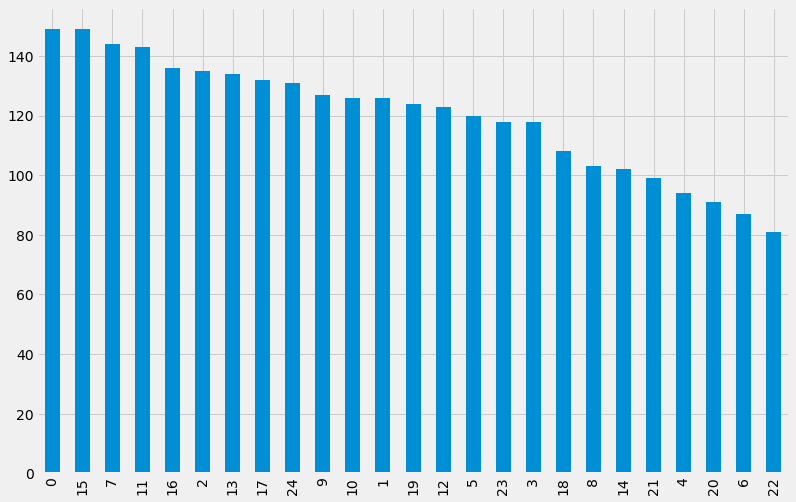

In [20]:
r_imp = pd.Series(data=rlearner.models_tau['treatment_A'].feature_importances_,
                  index=list(range(n_features)))
r_imp.sort_values(ascending=False).plot(kind='bar', figsize=(12,8))

In [157]:
explainer = lime.lime_tabular.LimeTabularExplainer(X,
                                                   feature_names=['Feature #{}'.format(i) for i in range(50)],
                                                   mode='regression')

In [181]:
i = 40
exp = explainer.explain_instance(X[i], lambda x: rlearner.predict(x).ravel(), num_features=10)

In [182]:
exp.as_list()

[('Feature #1 > 0.75', 0.2440262774642985),
 ('0.50 < Feature #0 <= 0.75', 0.07420381868396567),
 ('Feature #38 > 0.75', -0.02424363527122574),
 ('Feature #39 <= 0.25', -0.022937672726510625),
 ('0.51 < Feature #30 <= 0.75', 0.016848483747002263),
 ('0.50 < Feature #12 <= 0.75', 0.01628840944209221),
 ('Feature #8 <= 0.25', -0.014977385028813808),
 ('0.50 < Feature #6 <= 0.75', 0.014468539945050818),
 ('Feature #36 <= 0.25', 0.012226649814286042),
 ('0.50 < Feature #46 <= 0.75', 0.010924823153923017)]

In [183]:
exp.show_in_notebook(show_table=True)